In [ ]:
%pip install pymysql
%pip install sshtunnel
%pip install pandas

In [4]:
import pymysql
from sshtunnel import SSHTunnelForwarder
import paramiko
from os.path import expanduser
import pandas as pd

In [5]:
import numpy as np

In [6]:
import time
import matplotlib.pyplot as plt
import math

connection done
Users: 3005
query done
Recommender change events:  11418
Users switching at least once:  748
Median changes per user w/ at least 1 change:  3


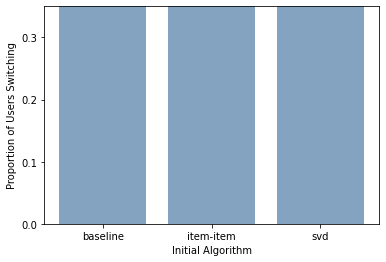

pattern:  ['item-item', 'pick-groups', 'svd'] count:  8 percentage:  3.2520325203252036
pattern:  ['baseline', 'item-item'] count:  45 percentage:  14.802631578947366
pattern:  ['item-item', 'svd'] count:  52 percentage:  21.138211382113823
pattern:  ['baseline', 'svd'] count:  45 percentage:  14.802631578947366
pattern:  ['baseline', 'item-item', 'svd'] count:  24 percentage:  7.894736842105263
pattern:  ['item-item', 'svd', 'item-item'] count:  23 percentage:  9.34959349593496
pattern:  ['svd', 'item-item', 'svd'] count:  21 percentage:  10.606060606060606
pattern:  ['svd', 'item-item'] count:  30 percentage:  15.151515151515152
pattern:  ['baseline', 'item-item', 'svd', 'item-item'] count:  12 percentage:  3.9473684210526314
pattern:  ['svd', 'pick-groups', 'svd'] count:  9 percentage:  4.545454545454546
pattern:  ['item-item', 'baseline', 'item-item'] count:  8 percentage:  3.2520325203252036
pattern:  ['baseline', 'svd', 'item-item'] count:  8 percentage:  2.631578947368421


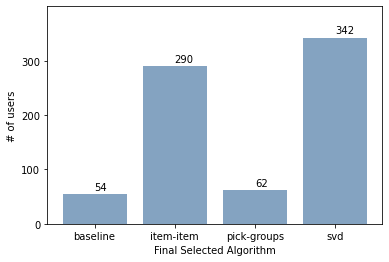

done


In [56]:
home = expanduser('~')
mypkey = paramiko.RSAKey.from_private_key_file( home + "/.ssh/id_rsa")

sql_hostname = '127.0.0.1'
sql_username = 'readonly'
sql_password = None
sql_main_database = 'ML3_mirror'
sql_port = 3306
ssh_host = 'flagon.cs.umn.edu'
ssh_user = 'kanna128'
ssh_port = 22
sql_ip = '1.1.1.1.1'

def draw_graph(values, labels, max_vals, scale):
  bars = plt.bar(range(len(values[1])), values[1], color=(0.2, 0.4, 0.6, 0.6))

  # print("type:", type(scale[1]))
  if((isinstance(scale[1], int))):
    for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + 0.5*bar.get_width(), yval + values[2], yval)

  xticks = []
  yticks = []

  if(scale[0] != 0):
    xmax = max_vals[0]
    xscale = scale[0]
    for k in np.arange(0, xmax, xscale):
      xticks.append(k)
    plt.xticks(xticks)
  else:
    plt.xticks(range(len(values[0])), values[0])
  
  ymax = max_vals[1]
  yscale = scale[1]

  for k in np.arange(0, ymax, yscale):
    yticks.append(k)
  plt.yticks(yticks)

  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  plt.ylim(0,max_vals[1])

  if(max_vals[0] != 0):
    plt.xlim(0, max_vals[0])
  
  plt.show()


BASELINE = "{\"engineId\":\"baseline\"}"
ITEM_ITEM = "{\"engineId\":\"item-item\"}"
SVD = "{\"engineId\":\"svd\"}"
PICK_GROUPS = "{\"engineId\":\"pick-groups\"}"

LONG_TO_SHORT = {BASELINE: "baseline", ITEM_ITEM: "item-item", SVD:"svd", PICK_GROUPS: "pick-groups"}
SHORT_TO_LONG = {"baseline": BASELINE, "item-item":ITEM_ITEM, "svd":SVD, "pick-groups":PICK_GROUPS}

def main_func():
  
  # SSH CONNECTION
  with SSHTunnelForwarder(
          (ssh_host, ssh_port),
          ssh_username=ssh_user,
          ssh_pkey=mypkey,
          remote_bind_address=(sql_hostname, sql_port)) as tunnel:
      conn = pymysql.connect(host='127.0.0.1', user=sql_username,
                              passwd=sql_password, db=sql_main_database,
                              port=tunnel.local_bind_port)
      print('connection done')

      # CALCULATING NUMBER OF USERS
      query_users = ''' SELECT expt_user.group, expt_user.userId from ML3_mirror.expt_user WHERE 
                        exptId = 'listcmp-long' AND started <'2015-04-01' 
                        AND status = 'RANDOMLY_ASSIGNED' '''
      users = pd.read_sql_query(query_users, conn)
      users_count = users.count()['group']
      print("Users: {}".format(users_count))

      recchange_dict = {} # dict to store key=userId, val=curralg in the iteration process

      # key=userId; val=number of changes
      changes_dict = {} # needed to later calculate median changes per user
      for k in range(users_count):
        userId = users.at[k, 'userId']
        group = ["{\"engineId\":\""+users.at[k, 'group']+"\"}"] # following the format of log_action.log_Json for future comparisons
        recchange_dict[userId] = (group,k)
        changes_dict[userId] = 0

      # NUMBER OF CHANGE EVENTS
      query_change = '''SELECT userId, logJson, tstamp, action from ML3_mirror.log_action WHERE EXISTS 
                        (SELECT userId from ML3_mirror.expt_user where expt_user.userId = log_action.userId 
                        AND expt_user.exptId='listcmp-long' 
                        AND expt_user.status='RANDOMLY_ASSIGNED') 
                        AND log_action.action='recommender-change' 
                        AND log_action.tstamp<'2015-04-01' ORDER BY log_action.tstamp'''
      change_events = pd.read_sql_query(query_change, conn)
      print("query done")
      change_events.sort_values(by=['userId'])

      length = change_events.count()['userId']
      
      # CREATING DICTIONARIES
      for i in range(length):
        userId = change_events.at[i, 'userId']
        recalg = change_events.at[i, 'logJson']
        if(recchange_dict[userId][0][-1] != recalg):
          changes_dict[userId] += 1
          recchange_dict[userId][0].append(recalg)
      
      num = 0
      for userId, recalg_tup in recchange_dict.items():
        recalg_list = recalg_tup[0]
        # num = recalg_tup[1]
        for userId, inner_tup in recchange_dict.items():
          if(inner_tup[0] == recalg_list):
            new_tup = (recalg_list,num)
            recchange_dict[userId] = new_tup
        num += 1

      # TABLE 1 RESULTS
      print("Recommender change events: ", sum(changes_dict.values()))
      changes_dict = {key:val for key,val in changes_dict.items() if val !=0}
      print("Users switching at least once: ", len(changes_dict.values()))
      print("Median changes per user w/ at least 1 change: ", int(np.median(list(changes_dict.values()))))

      baseline = 0
      item_item = 0
      svd = 0

      recchange_dict = {key:val for key,val in recchange_dict.items() if len(val[0])>1}
      patterns = {}
      for userId, recalg_tup in recchange_dict.items():
        recalg_list = recalg_tup[0]
        new_list = []
        for alg in recalg_list:
          new_alg = LONG_TO_SHORT[alg]
          new_list.append(new_alg)
        
        value = recalg_tup[1]
        new_tup = (new_list, value)
        recchange_dict[userId] = new_tup
        # if(len(recalg_tup[0])>1):
        patterns[value] = 0
      # print("patterns done")

      #key=algorithm, val=(no. of users initially assigned, no. of users initially assigned and switched at least once)
      count_dict = {"baseline":[0,0], "item-item":[0,0], "svd":[0,0], "pick-groups":[0,0]}
      # keys = count_dict.keys()
      # for key in keys:
      #   print(key)
      for userId,recalg_tup in recchange_dict.items():
        recalg = recalg_tup[0][0]
        count_dict[recalg][0] +=1
        if userId in changes_dict.keys():
          count_dict[recalg][1] += 1
          # if(recalg == BASELINE):
          #   baseline += 1
          # if(recalg == ITEM_ITEM):
          #   item_item += 1
          # if(recalg == SVD):
          #   svd += 1

      # print("RATIO 1: ", 30/count_dict[SVD][1])
      # print("RATIO 2: ", 21/count_dict[SVD][1])
      
      
      baseline = count_dict["baseline"][1]/count_dict["baseline"][0]
      item_item = count_dict["item-item"][1]/count_dict["item-item"][0]
      svd = count_dict["svd"][1]/count_dict["svd"][0]

      # FIGURE 2
      values = [["baseline", "item-item", "svd"], [baseline, item_item, svd], 0.01]
      draw_graph(values, ["Initial Algorithm", "Proportion of Users Switching"], [0, 0.35], [0, 0.1])
      
      # recchange_dict = {key:val for key,val in recchange_dict.items() if len(val[0])>1}
      # patterns = {}
      # for userId, recalg_tup in recchange_dict.items():
      #   recalg_list = recalg_tup[0]
      #   new_list = []
      #   for alg in recalg_list:
      #     new_alg = LONG_TO_SHORT[alg]
      #     new_list.append(new_alg)
        
      #   value = recalg_tup[1]
      #   new_tup = (new_list, value)
      #   recchange_dict[userId] = new_tup
      #   # if(len(recalg_tup[0])>1):
      #   patterns[value] = 0
      # # print("patterns done")


      
      k=0
      for recalg_tup in recchange_dict.values():

        # if(len(recalg_tup[0])==2):
        #   print(recalg_tup[0])
        # if(k==0):
        #   print(recalg_tup[0])
        # k=1
        # if(len(recalg_tup[0])>1):
        patterns[recalg_tup[1]] += 1
      # print(max(patterns.values()))

      # print("len before: ", len(patterns.values()))
      # patterns = {key:val for key,val in patterns.items() if val != 0}
      # print("len after: ", len(patterns.values()))
      
      keys_dict = {}
      
      # keys_set = set()
      for recalg_tup in recchange_dict.values():
        keys_dict[recalg_tup[1]] = 0
      # total = sum(patterns.values())
      # print("total: ", total)
      for userId, recalg_tup in recchange_dict.items():
        num = recalg_tup[1]
        initial = recalg_tup[0][0]
        # initial_cmp = SHORT_TO_LONG[initial]

        if num in patterns.keys():
          count = patterns[num]
        keys_dict[num] += 1
        if(count>7 and count<53 and keys_dict[num]==1):
          percentage = (count/count_dict[initial][1])*100
          # keys_set.add((num, count, percentage))
          # keys_set.add((recalg_tup[0], count, percentage))
          print("pattern: ", recalg_tup[0], "count: ", count, "percentage: ", percentage)

      # temp_dict = {BASELINE: "baseline", ITEM_ITEM: "item-item", SVD:"svd", PICK_GROUPS: "pick-groups"}
      # for elem in keys_set:
      #   print(elem)
      # loopvar = 0
      # for recalg_tup in recchange_dict.values():
      #   val = keys_set[loopvar][0]
      #   if recalg_tup[1] == val:
      #     print("alg: ", recalg_tup[0], " | count: ", keys_set[loopvar][1], " | percentage: ", keys_set[loopvar][2])
      #   loopvar += 1

      # for item in keys_set:
      #   temp_tup = item
      #   for recalg_tup in recchange_dict.values():
      #     if recalg_tup[1] == temp_tup[0]:
      #       print("alg: ", recalg_tup[0], " | count: ", temp_tup[1], " | percentage: ", temp_tup[2])

      # m = 0
      # for key, val in patterns.items():
      #   if(m<15):
      #     print("key: ", key, " | val: ", val)
      #   m += 1
      # for item in keys_set:
      #   print(item)
      # for recalg_tup in recchange_dict.values():
      #   if(recalg_tup[1] == 3004):
      #     print("tup:",recalg_tup)
      # for val in patterns.values():
      #   if(k<30):
      #     print(val)
      #   k += 1
      # expt_end_date - account_creation_date as a count of days

      ###############################################################################################
      for key in count_dict.keys():
        count_dict[key] = 0

      for userId, recalg_tup in recchange_dict.items():
        if(userId in changes_dict.keys()):
          alg = recalg_tup[0][-1]
          # alg_cmp = SHORT_TO_LONG[alg]
          count_dict[alg] += 1
      
      # baseline = count_dict[BASELINE]
      # item_item = count_dict[ITEM_ITEM]
      # pick_groups = count_dict[PICK_GROUPS]
      # svd = count_dict[SVD]
      
      # FIGURE 3
      values = [["baseline", "item-item", "pick-groups", "svd"], 
                [count_dict["baseline"], count_dict["item-item"], 
                count_dict["pick-groups"], count_dict["svd"]], 
                8]
      draw_graph(values, ["Final Selected Algorithm", "# of users"], [0, 400], [0, 100])
      ################################################################################################
if __name__ == "__main__":
  main_func()
  print('done')